In [ ]:
from six.moves import cPickle as pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
from torch import optim, cuda
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from PIL import Image

import torchvision.models as models

In [ ]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


## 0. Custom model definition

In [ ]:
class MyFCModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_part = nn.Sequential(
            nn.Linear(32*32*3, 1024, bias=True),
            nn.ReLU(),
            nn.Linear(1024, 1024, bias=True),
            nn.ReLU(),
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.Linear(128, 32, bias=True),
            nn.ReLU(),
            nn.Linear(32, num_classes, bias=True),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_part(x)
        return x

In [ ]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_part = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.linear_part = nn.Sequential(
            nn.Linear(64*16*16, 128, bias=True),
            nn.ReLU(),
            nn.Linear(128, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 32, bias=True),
            nn.ReLU(),
            nn.Linear(32, num_classes, bias=True),
        )
    
    def forward(self, x):
        x = self.conv_part(x)
        x = self.flatten(x)
        x = self.linear_part(x)
        return x

## 1. Total number of parameters

In [ ]:
print("Total parameter count")
num_classes = 10

model = MyFCModel(num_classes)
model.load_state_dict(torch.load("cifar_FC_best_model.pt"))
print("FC model: {0}".format(sum(p.numel() for p in model.parameters())))

model = MyCNNModel(num_classes)
model.load_state_dict(torch.load("cifar_my_cnn_best_model.pt"))
print("shallow CNN model: {0}".format(sum(p.numel() for p in model.parameters())))

model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10, True)
model.load_state_dict(torch.load("cifar_resnet18_best_model.pt"))
print("ResNet-18: {0}".format(sum(p.numel() for p in model.parameters())))

model = models.efficientnet_b0()
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
model.load_state_dict(torch.load("cifar_efficient_net_best_model.pt"))
print("EfficientNet-B0: {0}".format(sum(p.numel() for p in model.parameters())))

Total parameter count
FC model: 4889834
shallow CNN model: 2131530
ResNet-18: 11181642
EfficientNet-B0: 4020358


## 2. Training record
The data is from the four training files  
1. Fully connected
   1. Training time: 443.95 sec
   2. Training accuracy: 61.66%
   3. Training Loss: 1.0857	
   4. Validation accuracy: 53.64%
   5. Validation Loss: 1.3733
2. shallow CNN
   1. Training time: 407.51 sec
   2. Training accuracy: 72.96%
   3. Training Loss: 0.7861	
   4. Validation accuracy: 65.54%
   5. Validation Loss: 1.0563
3. ResNet-18
   1. Training time: 1453.37 sec
   2. Training accuracy: 77.13%
   3. Training Loss: 0.6464	
   4. Validation accuracy: 71.26%
   5. Validation Loss: 0.8514
4. EfficientNet-B0 (on Colab)
   1. Training time: 4516.78 sec
   2. Training accuracy: 84.15%
   3. Training Loss: 0.4547	
   4. Validation accuracy: 74.36%
   5. Validation Loss: 0.7434

## 3. Saliency Maps for each model

In [ ]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding="latin1")
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(root):
    test_datafile = os.path.join(root, "test_batch")
    meta_datafile = os.path.join(root, "batches.meta")
    
    xs = []
    ys = []
    for b in range(1,6):
        train_datafile = os.path.join(root, "data_batch_{0}".format(b))
        X, Y = load_CIFAR_batch(train_datafile)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    Y_train = np.concatenate(ys)
    
    X_test, Y_test = load_CIFAR_batch(test_datafile)

    with open(meta_datafile, "rb") as f:
        # this file includes the label index to name mapping
        datadict = pickle.load(f, encoding="latin1")
        labels = np.array(datadict["label_names"])

    return X_train, Y_train, X_test, Y_test, labels

def get_cifar10_data_unmodified():
    # Load the raw CIFAR-100 data
    cifar10_dir = "./datasets/"
    X_train, Y_train, X_test, Y_test, labels = load_CIFAR10(cifar10_dir)

    X_train = X_train.astype("float")
    X_test = X_test.astype("float")

    # although we don't need to subtract the mean now, we record it for preprocessing the data to feed into the model
    x_mean = np.mean(X_train, axis=0)

    Y_train = np.squeeze(Y_train)
    Y_test = np.squeeze(Y_test)

    print("X (training)   shape:", X_train.shape)
    print("Y (training)   shape:", Y_train.shape)
    print("X (test) shape:", X_test.shape)
    print("Y (test) shape:", Y_test.shape)

    return X_train, Y_train, X_test, Y_test, labels, x_mean

In [ ]:
def prepare_model(model, state_dict):
    if "resnet18" in state_dict:
        model.fc = nn.Linear(model.fc.in_features, 10, True)
    elif "efficient" in state_dict:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)
    model.load_state_dict(torch.load(state_dict))
    model.optimizer = optim.SGD(model.parameters(), lr=0.01)
    model.cuda()
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

In [ ]:
NUM_CLASSES = 10
MODEL_LIST = [MyFCModel(NUM_CLASSES), MyCNNModel(NUM_CLASSES), models.resnet18(), models.efficientnet_b0()]
MODEL_NAMES = ["FC", "CNN", "ResNet", "EfficientNet"]
STATE_DICTS = ["cifar_FC_best_model.pt", "cifar_my_cnn_best_model.pt", "cifar_resnet18_best_model.pt", "cifar_efficient_net_best_model.pt"]

In [ ]:
def plot_saliency_4_models(labels, img_idx, true_label_idx, original_img, x_mean):
    # transform the image to torch.Tensor, subtract the mean
    sub_img = original_img - x_mean
    sub_img = np.reshape(sub_img, (1, sub_img.shape[0], sub_img.shape[1], sub_img.shape[2]))
    input = torch.from_numpy(sub_img).float().cuda()
    
    # we need the gradient with respect to the input
    input.requires_grad = True

    for i in range(len(MODEL_LIST)):
        model = MODEL_LIST[i]
        prepare_model(model, STATE_DICTS[i])
        y_pred = model(input)

        score, indices = torch.max(y_pred, dim=1)
        # back propagate the score to get gradients
        score.backward()
        # find the maximum gradients
        max_grad, _ = torch.max(torch.abs(input.grad[0]), dim=0)
        # normalize to [0,1]
        max_grad = (max_grad - max_grad.min()) / (max_grad.max() - max_grad.min())
        max_grad = max_grad.cpu().numpy()
        max_grad_constrained = np.where(max_grad >= 0.5, 1, 0)

        plt.figure(figsize=(10, 10))
        plt.subplot(4, 4, 4*i+1)
        plt.title("img {0} label {1} \n predicted as {2} by {3}".format(img_idx, labels[true_label_idx], labels[indices.detach().cpu().numpy()[0]], MODEL_NAMES[i]))
        # the original image data is C*H*W, but for plotting, we need H*W*C
        arr = np.transpose(original_img, (1, 2, 0))
        im = Image.fromarray(np.array(arr, dtype=np.uint8))
        plt.imshow(im)

        plt.subplot(4, 4, 4*i+2)
        # plot the saliency map
        plt.title("saliency map")
        plt.imshow(max_grad, cmap=plt.cm.hot)

        plt.subplot(4, 4, 4*i+3)
        # plot the constrained saliency map for better visualization
        plt.title("saliency map 2")
        plt.imshow(max_grad_constrained, cmap=plt.cm.hot)

        plt.subplot(4, 4, 4*i+4)
        plt.title("composed saliency +\n original image")
        max_grad_idx_y, max_grad_idx_x = np.where(max_grad >= 0.5)
        plt.scatter(max_grad_idx_x, max_grad_idx_y)
        plt.imshow(im)
        plt.show()

Load the models and generate saliency maps

In [ ]:
X_train, Y_train, X_test, Y_test, labels, x_mean = get_cifar10_data_unmodified()

X (training)   shape: (50000, 3, 32, 32)
Y (training)   shape: (50000,)
X (test) shape: (10000, 3, 32, 32)
Y (test) shape: (10000,)


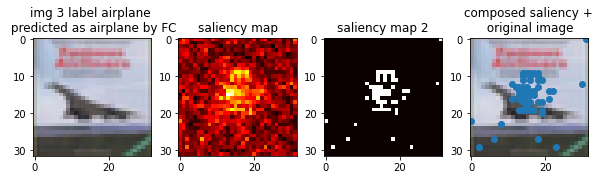

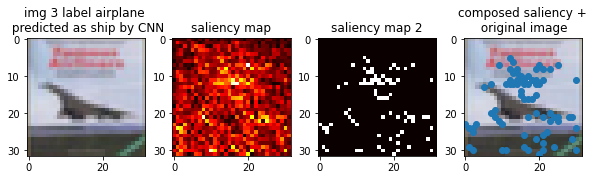

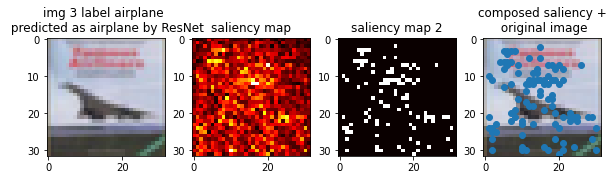

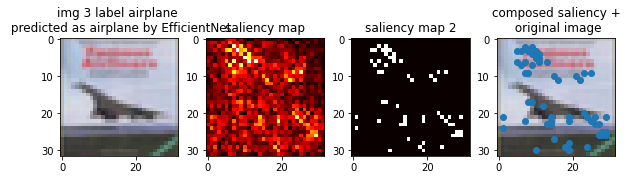

In [ ]:
plot_saliency_4_models(labels, 3, Y_test[3], X_test[3], x_mean)

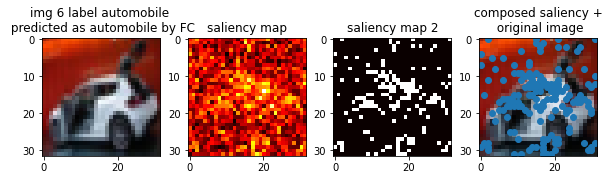

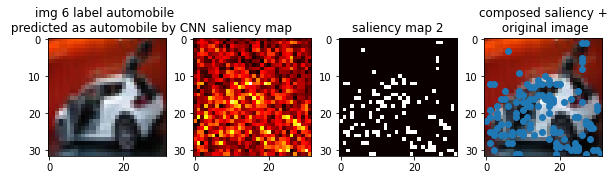

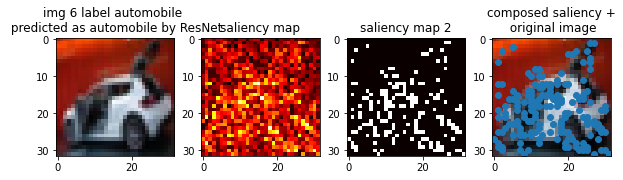

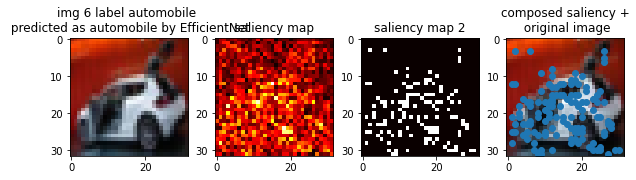

In [ ]:
plot_saliency_4_models(labels, 6, Y_test[6], X_test[6], x_mean)

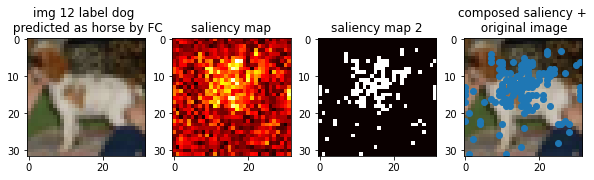

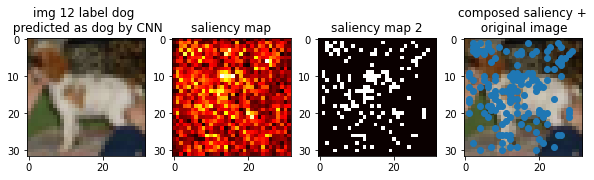

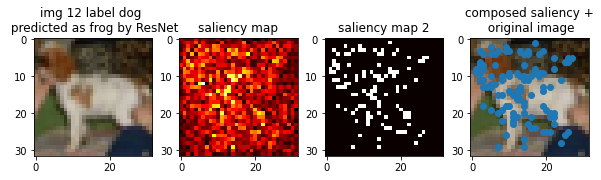

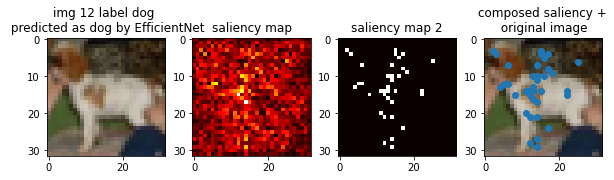

In [ ]:
plot_saliency_4_models(labels, 12, Y_test[12], X_test[12], x_mean)

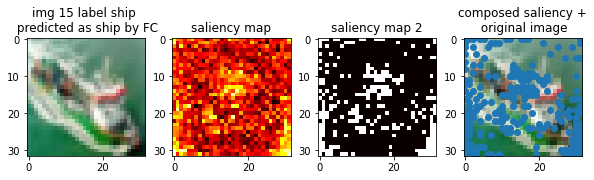

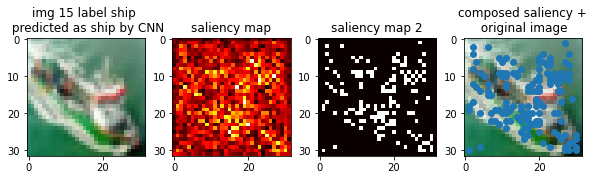

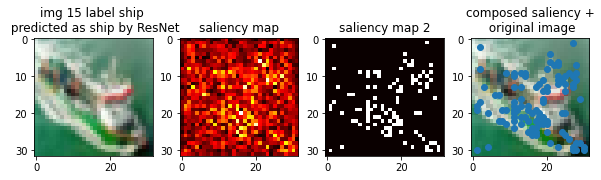

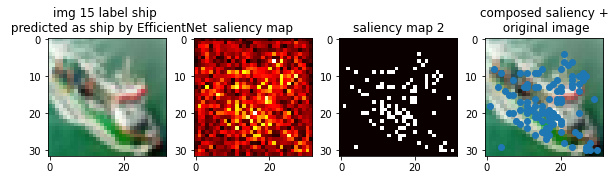

In [ ]:
plot_saliency_4_models(labels, 15, Y_test[15], X_test[15], x_mean)

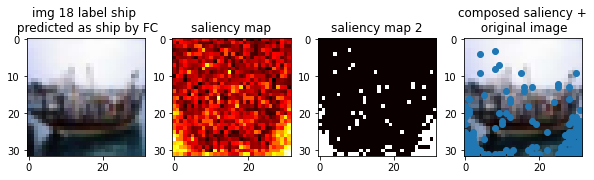

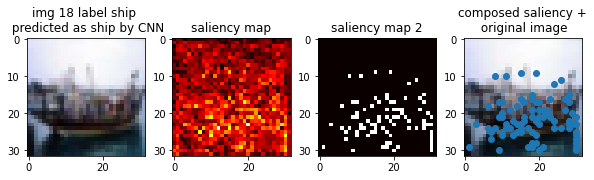

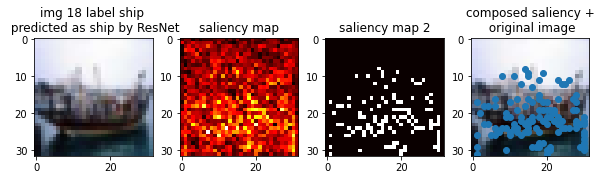

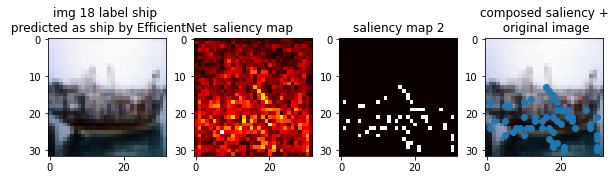

In [ ]:
plot_saliency_4_models(labels, 18, Y_test[18], X_test[18], x_mean)

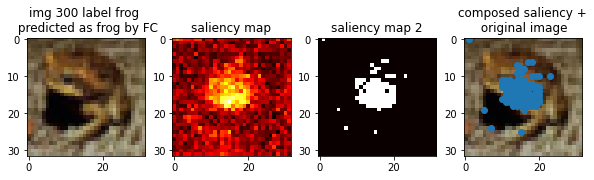

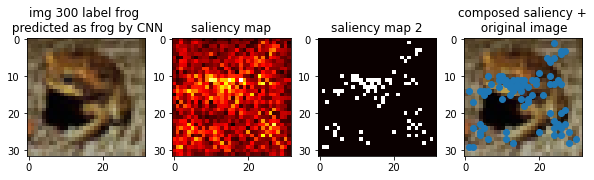

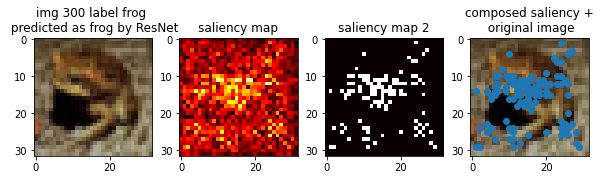

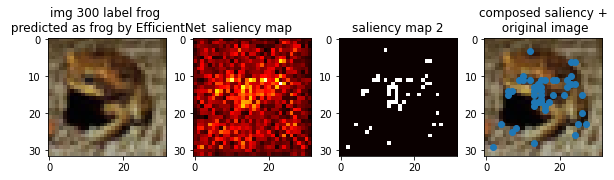

In [ ]:
plot_saliency_4_models(labels, 300, Y_test[300], X_test[300], x_mean)

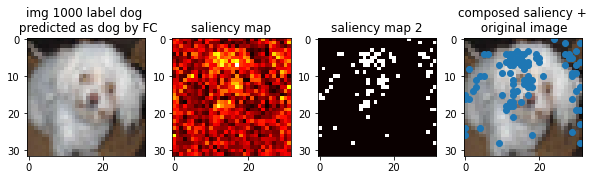

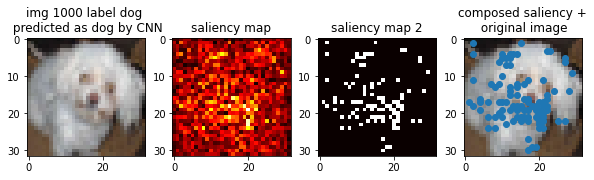

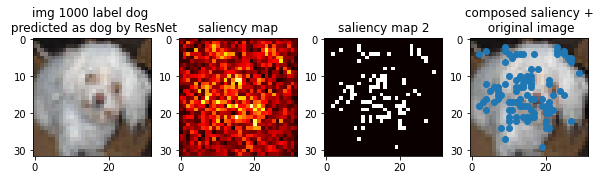

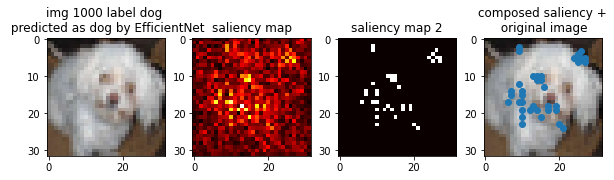

In [ ]:
plot_saliency_4_models(labels, 1000, Y_test[1000], X_test[1000], x_mean)

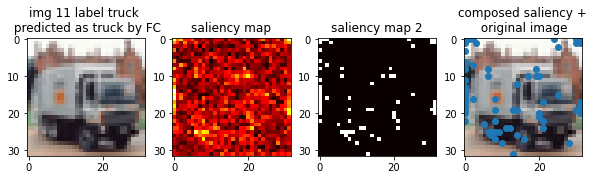

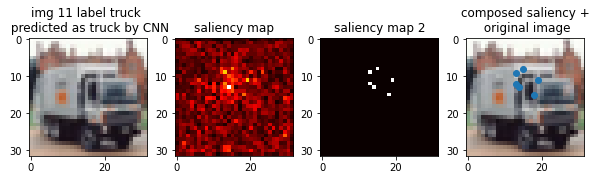

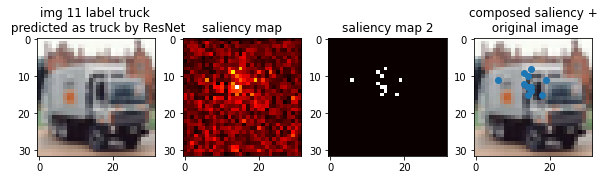

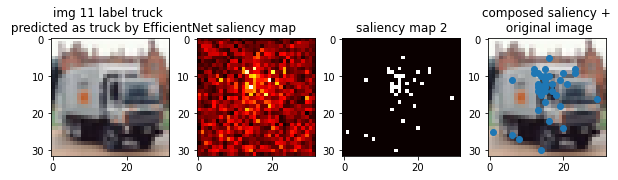

In [ ]:
plot_saliency_4_models(labels, 11, Y_test[11], X_test[11], x_mean)

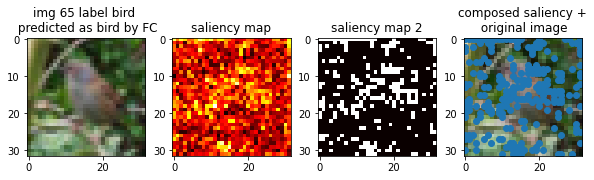

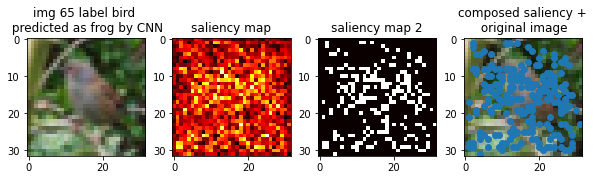

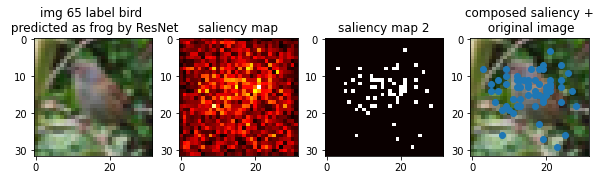

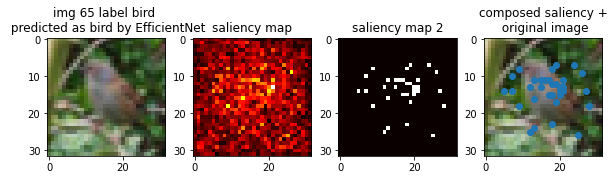

In [ ]:
plot_saliency_4_models(labels, 65, Y_test[65], X_test[65], x_mean)

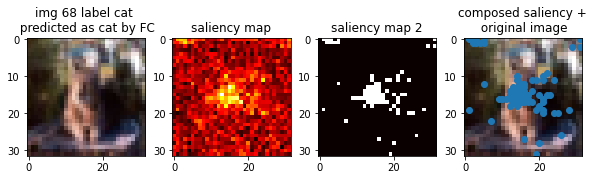

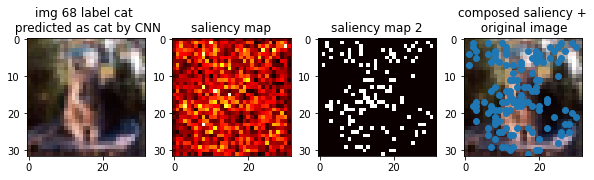

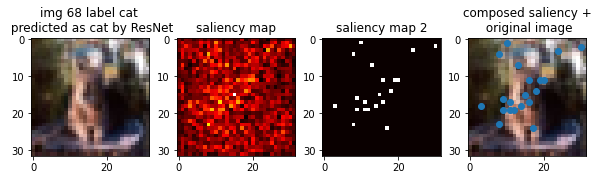

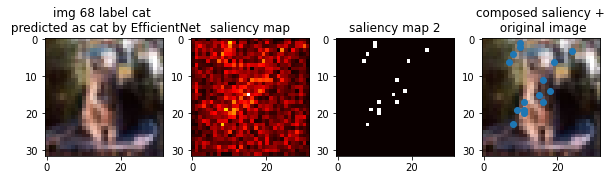

In [ ]:
plot_saliency_4_models(labels, 68, Y_test[68], X_test[68], x_mean)

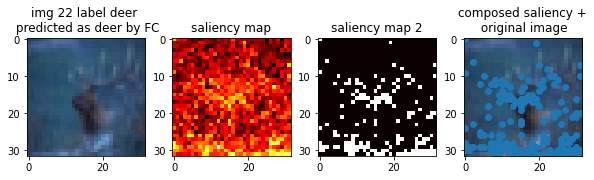

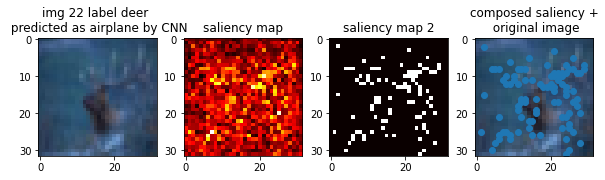

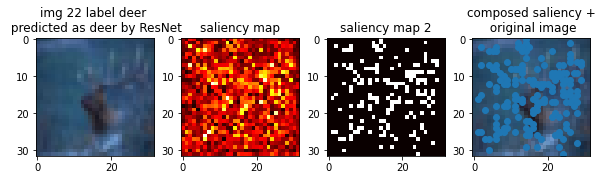

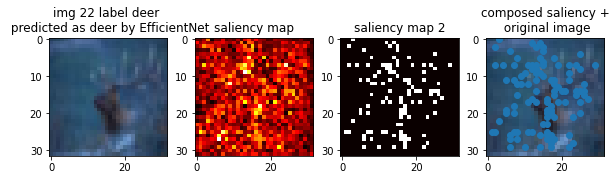

In [ ]:
plot_saliency_4_models(labels, 22, Y_test[22], X_test[22], x_mean)

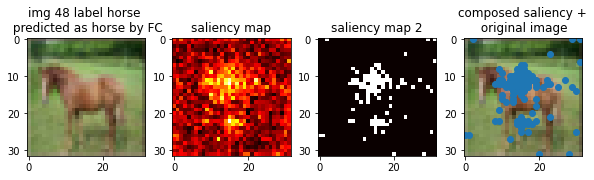

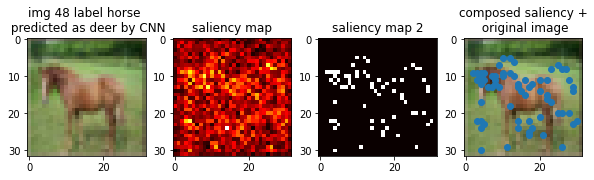

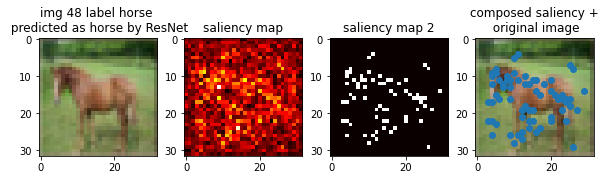

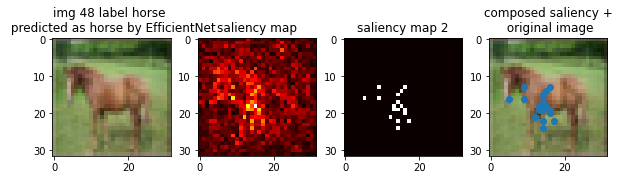

In [ ]:
plot_saliency_4_models(labels, 48, Y_test[48], X_test[48], x_mean)